In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
from PIL import Image


In [2]:
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [4]:
models = {
    'Shallow MLP': nn.Sequential(
        nn.Linear(128*128, 32),
        nn.ReLU(),
        nn.Linear(32, 3)
    ),
    'Deep MLP': nn.Sequential(
        nn.Linear(128*128, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 3)
    ),
    'Shallow CNN': nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16*64*64, 3) 
    ),
    'Deep CNN': nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(64*32*32, 128),  
        nn.ReLU(),
        nn.Linear(128, 3)
    )

}

In [5]:
class AIdetec_CNN(Dataset):
    def __init__(self, data_dir="data", img_size=128):
        self.data_dir = data_dir
        self.img_dir = os.path.join(data_dir, "initial_data")
        self.df = pd.read_csv(os.path.join(data_dir, "initial_data.csv"))
        
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = os.path.basename(row["file_name"])  
        label = int(row["label"])

        img_path = os.path.join(self.img_dir, img_name)
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"No se encontró la imagen: {img_path}")

        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        return img, label


In [6]:
class AIdetec_MLP(Dataset):
    def __init__(self, data_dir="data", img_size=128):
        self.data_dir = data_dir
        self.img_dir = os.path.join(data_dir, "initial_data")
        self.df = pd.read_csv(os.path.join(data_dir, "initial_data.csv"))
        
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Grayscale(),
            transforms.Lambda(lambda x: x.view(-1))
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = os.path.basename(row["file_name"])  
        label = int(row["label"])

        img_path = os.path.join(self.img_dir, img_name)
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"No se encontró la imagen: {img_path}")

        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        return img, label


In [7]:
dataset_CNN = AIdetec_CNN('../data', 128)

train_size_CNN = 800    
val_size_CNN = 200

train_CNN, val_CNN = random_split(dataset_CNN, [train_size_CNN, val_size_CNN])




dataset_MLP = AIdetec_MLP('../data', 128)

train_size_MLP = 800    
val_size_MLP = 200

train_MLP, val_MLP = random_split(dataset_MLP, [train_size_MLP, val_size_MLP])

In [8]:
dl_train_CNN = DataLoader(train_CNN, batch_size=32, shuffle=True)
dl_val_CNN = DataLoader(val_CNN, batch_size=32, shuffle=True)

dl_train_MLP = DataLoader(train_MLP, batch_size=32, shuffle=True)
dl_val_MLP = DataLoader(val_MLP, batch_size=32, shuffle=True)

In [9]:
size = 0
for batch_x, batch_y in dl_train_MLP:
  size += batch_x.shape[0]
  print(batch_x.shape), print(batch_y.shape)
print("Total size: ", size)

torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 16384])
torch.Size([32])
torch.Size([32, 

In [10]:
def train_model(model, train_dl, val_dl, epochs=1000, lr=0.1):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0

        for batch_x, batch_y in train_dl:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_correct += (predicted == batch_y).sum().item()

        train_loss_history.append(train_loss / len(train_dl))
        train_acc_history.append(train_correct / len(train_dl.dataset))

        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for batch_x, batch_y in val_dl:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                output = model(batch_x)
                loss = criterion(output, batch_y)
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_correct += (predicted == batch_y).sum().item()

        val_loss_history.append(val_loss / len(val_dl))
        val_acc_history.append(val_correct / len(val_dl.dataset))
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}, Train Loss: {train_loss_history[-1]:.4f}, Train Acc: {train_acc_history[-1]:.4f}, Val Loss: {val_loss_history[-1]:.4f}, Val Acc: {val_acc_history[-1]:.4f}")



    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


In [11]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(models['Shallow MLP'], dl_train_MLP, dl_val_MLP, epochs=100, lr=0.0001)

Epoch 0, Train Loss: 0.7704, Train Acc: 0.5000, Val Loss: 0.7440, Val Acc: 0.4700
Epoch 10, Train Loss: 0.6458, Train Acc: 0.6162, Val Loss: 0.6940, Val Acc: 0.5700
Epoch 20, Train Loss: 0.6065, Train Acc: 0.6863, Val Loss: 0.7479, Val Acc: 0.4600
Epoch 30, Train Loss: 0.5792, Train Acc: 0.7087, Val Loss: 0.7034, Val Acc: 0.5200
Epoch 40, Train Loss: 0.5511, Train Acc: 0.7425, Val Loss: 0.7430, Val Acc: 0.5400
Epoch 50, Train Loss: 0.5196, Train Acc: 0.7562, Val Loss: 0.7341, Val Acc: 0.4900
Epoch 60, Train Loss: 0.4796, Train Acc: 0.8013, Val Loss: 0.7320, Val Acc: 0.5300
Epoch 70, Train Loss: 0.4937, Train Acc: 0.7600, Val Loss: 0.7475, Val Acc: 0.5050
Epoch 80, Train Loss: 0.4392, Train Acc: 0.8063, Val Loss: 0.8360, Val Acc: 0.5600
Epoch 90, Train Loss: 0.3987, Train Acc: 0.8600, Val Loss: 0.8068, Val Acc: 0.5600
Epoch 99, Train Loss: 0.3871, Train Acc: 0.8712, Val Loss: 0.8492, Val Acc: 0.5200


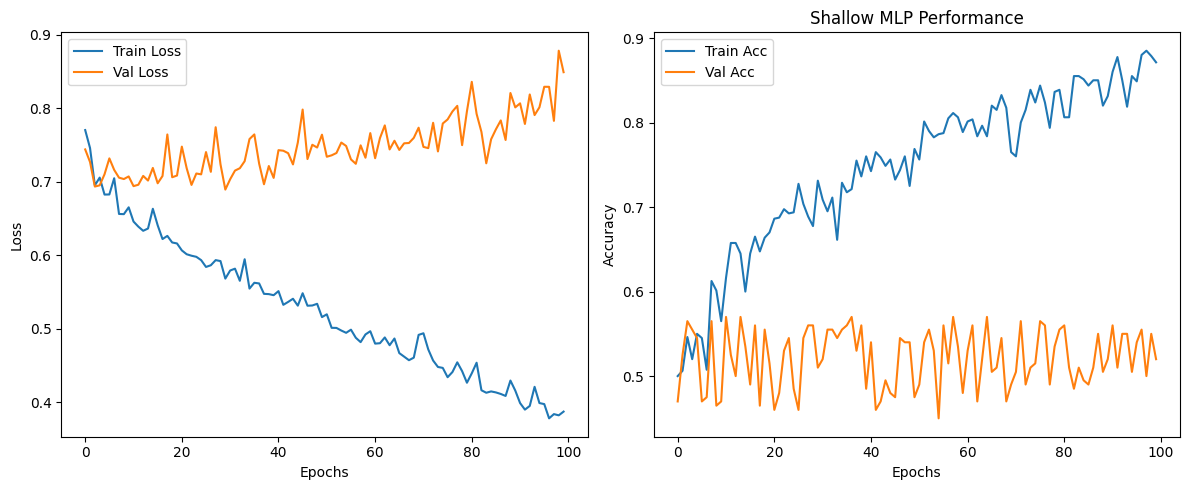

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Shallow MLP Performance')
plt.tight_layout()
plt.show()

In [13]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(models['Deep MLP'], dl_train_MLP, dl_val_MLP, epochs=100, lr=0.0001)

Epoch 0, Train Loss: 0.7993, Train Acc: 0.4838, Val Loss: 0.7038, Val Acc: 0.5300
Epoch 10, Train Loss: 0.7045, Train Acc: 0.5513, Val Loss: 0.7144, Val Acc: 0.4800
Epoch 20, Train Loss: 0.6405, Train Acc: 0.6312, Val Loss: 0.7039, Val Acc: 0.5700
Epoch 30, Train Loss: 0.5657, Train Acc: 0.7175, Val Loss: 0.7507, Val Acc: 0.5500
Epoch 40, Train Loss: 0.4922, Train Acc: 0.7600, Val Loss: 0.7518, Val Acc: 0.5250
Epoch 50, Train Loss: 0.3222, Train Acc: 0.8875, Val Loss: 0.8220, Val Acc: 0.5900
Epoch 60, Train Loss: 0.2618, Train Acc: 0.8925, Val Loss: 1.8826, Val Acc: 0.5900
Epoch 70, Train Loss: 0.1662, Train Acc: 0.9463, Val Loss: 1.1256, Val Acc: 0.5950
Epoch 80, Train Loss: 0.1327, Train Acc: 0.9625, Val Loss: 1.1836, Val Acc: 0.6150
Epoch 90, Train Loss: 0.1870, Train Acc: 0.9300, Val Loss: 2.0235, Val Acc: 0.5850
Epoch 99, Train Loss: 0.0772, Train Acc: 0.9825, Val Loss: 1.6504, Val Acc: 0.5850


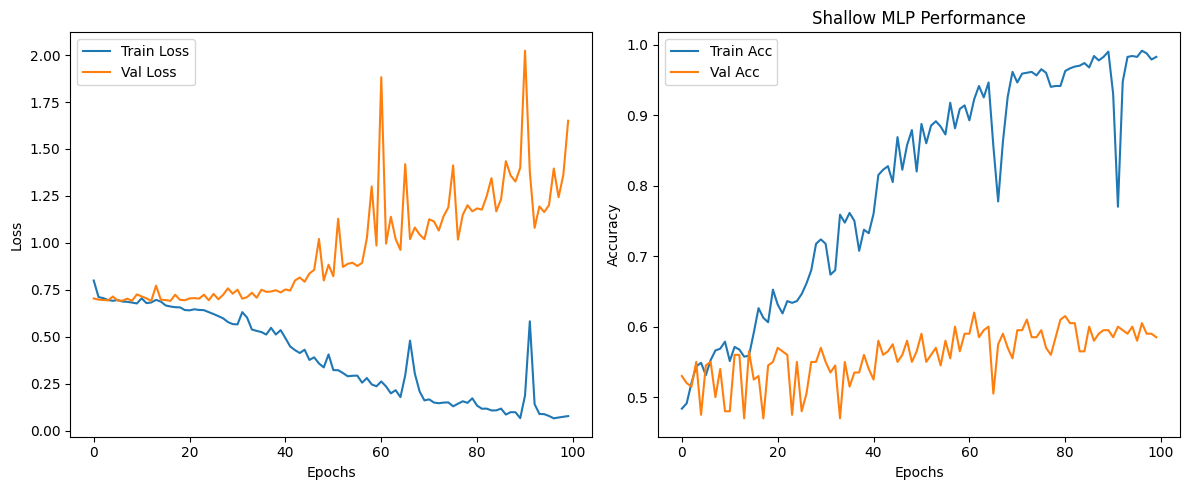

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Shallow MLP Performance')
plt.tight_layout()
plt.show()

In [15]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(models['Shallow CNN'], dl_train_CNN, dl_val_CNN, epochs=100, lr=0.0001)

Epoch 0, Train Loss: 0.6679, Train Acc: 0.6088, Val Loss: 0.5874, Val Acc: 0.7100
Epoch 10, Train Loss: 0.2402, Train Acc: 0.9300, Val Loss: 0.3387, Val Acc: 0.8750
Epoch 20, Train Loss: 0.1477, Train Acc: 0.9712, Val Loss: 0.3430, Val Acc: 0.8850
Epoch 30, Train Loss: 0.0958, Train Acc: 0.9888, Val Loss: 0.3103, Val Acc: 0.8850
Epoch 40, Train Loss: 0.0645, Train Acc: 0.9950, Val Loss: 0.3073, Val Acc: 0.8850
Epoch 50, Train Loss: 0.0463, Train Acc: 0.9988, Val Loss: 0.2851, Val Acc: 0.8650
Epoch 60, Train Loss: 0.0330, Train Acc: 1.0000, Val Loss: 0.2935, Val Acc: 0.8650
Epoch 70, Train Loss: 0.0254, Train Acc: 1.0000, Val Loss: 0.2996, Val Acc: 0.8650
Epoch 80, Train Loss: 0.0192, Train Acc: 1.0000, Val Loss: 0.3732, Val Acc: 0.8550
Epoch 90, Train Loss: 0.0154, Train Acc: 1.0000, Val Loss: 0.3765, Val Acc: 0.8600
Epoch 99, Train Loss: 0.0120, Train Acc: 1.0000, Val Loss: 0.3204, Val Acc: 0.8650


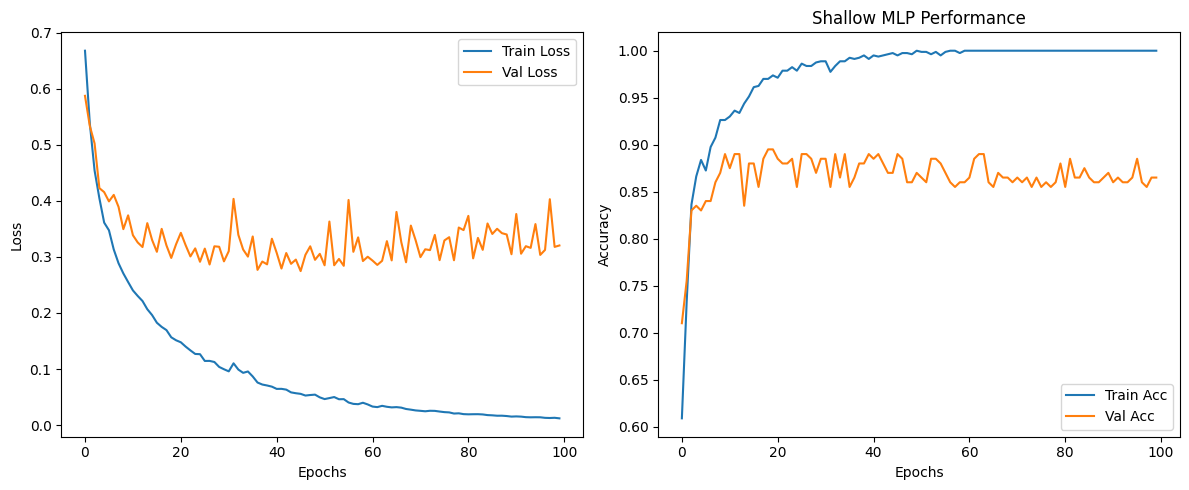

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Shallow MLP Performance')
plt.tight_layout()
plt.show()

In [17]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(models['Deep CNN'], dl_train_CNN, dl_val_CNN, epochs=100, lr=0.0001)

Epoch 0, Train Loss: 0.6845, Train Acc: 0.5713, Val Loss: 0.6252, Val Acc: 0.5150
Epoch 10, Train Loss: 0.1990, Train Acc: 0.9375, Val Loss: 0.3061, Val Acc: 0.8700
Epoch 20, Train Loss: 0.1272, Train Acc: 0.9613, Val Loss: 0.2984, Val Acc: 0.8750
Epoch 30, Train Loss: 0.0654, Train Acc: 0.9888, Val Loss: 0.2873, Val Acc: 0.8950
Epoch 40, Train Loss: 0.0378, Train Acc: 0.9938, Val Loss: 0.3487, Val Acc: 0.8850
Epoch 50, Train Loss: 0.0214, Train Acc: 0.9988, Val Loss: 0.3248, Val Acc: 0.8850
Epoch 60, Train Loss: 0.0121, Train Acc: 1.0000, Val Loss: 0.4760, Val Acc: 0.8750
Epoch 70, Train Loss: 0.0070, Train Acc: 1.0000, Val Loss: 0.3372, Val Acc: 0.8850
Epoch 80, Train Loss: 0.0043, Train Acc: 1.0000, Val Loss: 0.3808, Val Acc: 0.8800
Epoch 90, Train Loss: 0.0029, Train Acc: 1.0000, Val Loss: 0.4340, Val Acc: 0.8750
Epoch 99, Train Loss: 0.0021, Train Acc: 1.0000, Val Loss: 0.3921, Val Acc: 0.8750


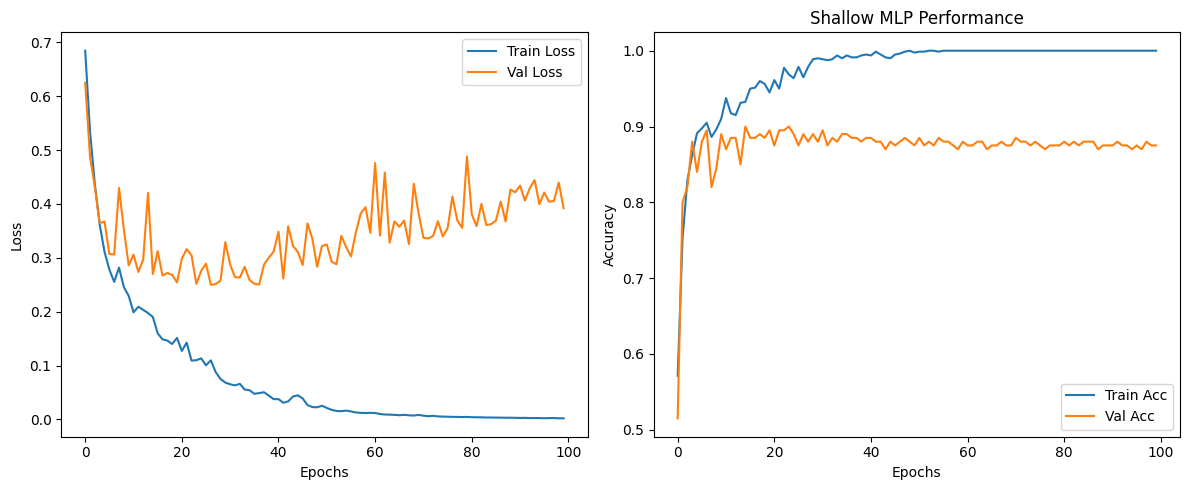

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Shallow MLP Performance')
plt.tight_layout()
plt.show()